# NeuralWorks - Challenge Data Engineer - Felipe Franco

# Descripción del proyecto

Como Data Engineer en este proyecto te ha tocado apoyar con la creación de turnos entre personas con viajes
similares. Para esto hemos adjuntado un CSV con una muestra de la data de los viajes realizados en 3 regiones. La Data Scientist del equipo necesita tu ayuda para poder hacer un análisis profundo de los datos y construir un modelo de machine learning. Te ha pedido cumplir con los siguientes requisitos:

1. Procesos automatizados para ingerir y almacenar los datos bajo demanda
 - a. Los viajes que son similares en términos de origen, destino y hora del día deben agruparse. Describa el enfoque que utilizó para agregar viajes similares.
2. Un servicio que es capaz de proporcionar la siguiente funcionalidad:
 - a. Devuelve el promedio semanal de la cantidad de viajes para un área definida por un bounding box y la región
 - b. Informar sobre el estado de la ingesta de datos sin utilizar una solución de polling
3. La solución debe ser escalable a 100 millones de entradas. Se recomienda simplificar los datos mediante un modelo de datos. Agregue pruebas de que la solución es escalable.
4. La solución debe estar escrita en Python usando una base de datos SQL
5. Puntos de bonificación si incluye su solución en contenedores y si dibuja cómo configuraría la aplicación en GCP


# Contexto de la solución

Dado que el proyecto busca generar análisis de datos con alta volumetría se propone tratarlos en la nube.
Para ello propongo una solución usando las herramientas de Azure: Data Factory, Databricks y Blob Storage. Esta tecnología es escalable y permite el tratamiento de Big Data.
El enfoque propuesto busca ingestar los datos desde su origen a la nube, para luego hacer análisis y transformaciones usando databricks. Esto facilita el trabajo a posteriori para los data engineers y los data scientists, pues databricks permite el uso de lenguaje SQL así como también Spark, PySpark, Python, librerías de Python como NumPy, Pandas y otras más especializadas como por ejemplo Azure Form Recognizer


# Desarrollo

Los orígenes de los datos pueden ser de distinta naturaleza, como por ejemplo, sharepoints, .json, .csv, Postgres SQL, Microsoft SQL, MySQL u otro. Mediante Data Factory es posible orquestar todos estos orígenes y tratarlos de forma similar mediante la metodología: Ingesta - Landing – Trusted y Refined. Siendo este último paso el que dejará el dato refinado para el uso del cientista de datos con Machine Learning.
Cada uno de estos pasos representan tratamientos que se les harán a los datos. Donde la ingesta son los archivos en crudo (.csv, .json, .xlsx, .avro) y las etapas siguientes ya son archivos .parquet que permiten una configuración óptima para consultas y tratamientos de datos con alta volumetría.
En cuanto a la frecuencia con que se actualicen los datos, depende de la necesidad. Para efectos de este ejercicio se ingestará una sola vez la tabla y se trabajará con ella asumiendo que estamos en el dia_i del análisis. Para que el flujo funcione diariamente o durante más veces en el día basta con tan solo agregar un trigger en DataFactory con la frecuencia deseada.

## Flujo propuesto:

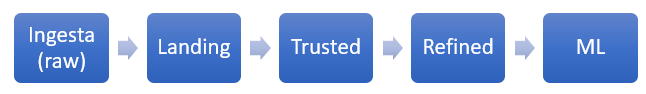

Notas:
-	Los “outputs” de cada uno de estos pasos son tablas que se arman con múltiples archivos .parquet almacenados en Microsoft Blob Storage.
-	Cada paso es orquestado mediante una canalización en Data Factory.
Las capas Landing y Trusted permiten la limpieza de los datos per se. Asumamos que a pesar de ser distitntos los orígenes, las tablas que se ingestan poseen la misma estructura que el .csv de ejemplo.
En la capa Landing se declara explícitamente el esquema de la tabla cruda (raw). Esto se realiza mediante un archivo de esquemas en formato .json y se usa Data Factory para pasar el archivo crudo al formato .parquet. 
-	El archivo de esquemas se puede generar automáticamente usando librerías haciendo un infer schema o manualmente.
Luego sigue la capa “Trusted” en la que es posible hacer transformaciones más específicas a la tabla, así como también efectuar limpiezas. Por ejemplo, se pueden tratar las incoherencias de los datos como lo son los carácteres extraños, los vacíos u otros. Para ello se genera un archivo de parámetros (.json) y se estructura la canalización en Data Factory. Esta canalización hace el paso de la tabla Landing a la tabla Trusted.
Finalmente se hará un caso de uso dentro de la capa Refined donde mediante lógicas en un notebook de databricks, se procede a responder a las solicitudes del cientista de datos. 
Para efectos de este ejercicio, este notebook solo utilizará la tabla Trusted que proviene del orígen de datos de “trips”. Pero es posible combinar más tablas para análisis más complejos.
Es por ello que en esta capa Refined también se utiliza un archivo de parámetros, donde se declaran todas las tablas que se usarán en la lógica del notebook (que en este caso solo es la tabla trips). También se utilizará una canalización en Data Factory que usará: el notebook de databricks y el archivo de parámetros.
El resultado de esta capa Refined es una tabla bajo el concepto de “caso de uso” que tiene las funcionalidades solicitadas por el cientista de datos para posteriores análisis de Machine Learning, por ejemplo.


## 1. Ingesta
### Tabla en SQL Server

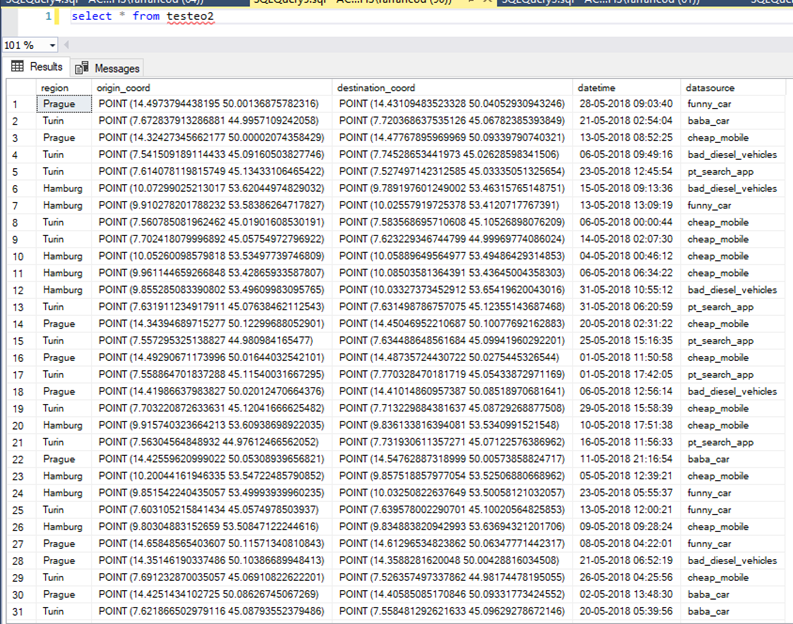

## Canalización de Ingesta al datalake

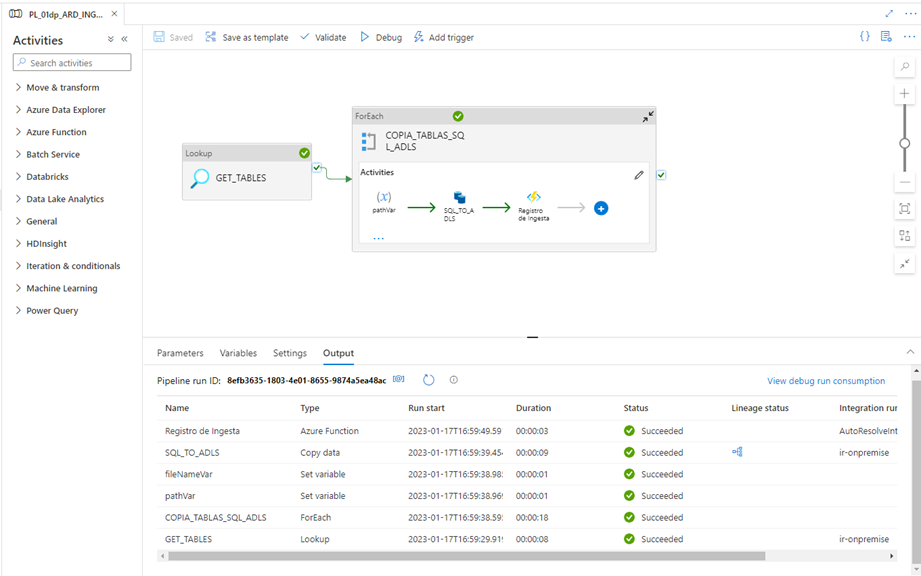

## Código de Ingesta

{
    "name": "PL_01dp_ARD_INGEST_TRIPS",
    "properties": {
        "description": "Pipeline para ingestar datos SQL...",
        "activities": [
            {
                "name": "GET_TABLES",
                "description": "Busca los nombres de tablas en instancia SQL SERVER, crea lista para recorrer en el copy_data",
                "type": "Lookup",
                "dependsOn": [],
                "policy": {
                    "timeout": "0.01:00:00",
                    "retry": 0,
                    "retryIntervalInSeconds": 30,
                    "secureOutput": false,
                    "secureInput": false
                },
                "userProperties": [],
                "typeProperties": {
                    "source": {
                        "type": "SqlServerSource",
                        "sqlReaderQuery": "SELECT \n\t* \nFROM \n\tINFORMATION_SCHEMA.TABLES\nWHERE (table_schema = 'dbo')\nAND table_name IN ('TESTEO2')\n\n",
                        "queryTimeout": "02:00:00",
                        "partitionOption": "None"
                    },
                    "dataset": {
                        "referenceName": "DS_SQL_AZ_MD",
                        "type": "DatasetReference",
                        "parameters": {
                            "tableName": "TABLES",
                            "schemaName": "INFORMATION_SCHEMA"
                        }
                    },
                    "firstRowOnly": false
                }
            },
            {
                "name": "COPIA_TABLAS_SQL_ADLS",
                "description": "Ejecuta ciclo EACH sobre el listado obtenido de GET_TABLES",
                "type": "ForEach",
                "dependsOn": [
                    {
                        "activity": "GET_TABLES",
                        "dependencyConditions": [
                            "Succeeded"
                        ]
                    }
                ],
                "userProperties": [],
                "typeProperties": {
                    "items": {
                        "value": "@activity('GET_TABLES').output.value",
                        "type": "Expression"
                    },
                    "isSequential": true,
                    "activities": [
                        {
                            "name": "SQL_TO_ADLS",
                            "description": "Copia datos desde instancia SQL EXPERIENCIA DE SERVICIO a AZURE DATA LAKE LANDING",
                            "type": "Copy",
                            "dependsOn": [
                                {
                                    "activity": "pathVar",
                                    "dependencyConditions": [
                                        "Succeeded"
                                    ]
                                },
                                {
                                    "activity": "fileNameVar",
                                    "dependencyConditions": [
                                        "Succeeded"
                                    ]
                                }
                            ],
                            "policy": {
                                "timeout": "2.00:00:00",
                                "retry": 0,
                                "retryIntervalInSeconds": 30,
                                "secureOutput": false,
                                "secureInput": false
                            },
                            "userProperties": [],
                            "typeProperties": {
                                "source": {
                                    "type": "SqlServerSource",
                                    "sqlReaderQuery": {
                                        "value": "SELECT *  FROM @{item().Table_Schema}.@{item().Table_Name}",
                                        "type": "Expression"
                                    },
                                    "partitionOption": "None"
                                },
                                "sink": {
                                    "type": "AvroSink",
                                    "storeSettings": {
                                        "type": "AzureBlobFSWriteSettings",
                                        "maxConcurrentConnections": 12
                                    },
                                    "formatSettings": {
                                        "type": "AvroWriteSettings"
                                    }
                                },
                                "enableStaging": false,
                                "parallelCopies": 10,
                                "translator": {
                                    "type": "TabularTranslator",
                                    "typeConversion": true,
                                    "typeConversionSettings": {
                                        "allowDataTruncation": true,
                                        "treatBooleanAsNumber": false
                                    }
                                }
                            },
                            "inputs": [
                                {
                                    "referenceName": "DS_SQL_AZ_MD",
                                    "type": "DatasetReference",
                                    "parameters": {
                                        "tableName": "TABLES",
                                        "schemaName": "INFORMATION_SCHEMA"
                                    }
                                }
                            ],
                            "outputs": [
                                {
                                    "referenceName": "DS_ADLS_LANDING_AVRO_DynamicFileName",
                                    "type": "DatasetReference",
                                    "parameters": {
                                        "FilePath": {
                                            "value": "@variables('Destination_PATH')",
                                            "type": "Expression"
                                        },
                                        "FileName": {
                                            "value": "@variables('Destination_FileName')",
                                            "type": "Expression"
                                        }
                                    }
                                }
                            ]
                        },
                        {
                            "name": "pathVar",
                            "description": "Variable que define path de archivos. ",
                            "type": "SetVariable",
                            "dependsOn": [],
                            "userProperties": [],
                            "typeProperties": {
                                "variableName": "Destination_PATH",
                                "value": {
                                    "value": "@concat(pipeline().parameters.folderPath_Destination,'/trips',item().Table_Name,'/raw/',\nformatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'yyyy'),'/'\n,formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'MM'),'/'\n,formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'dd'),'/'\n,formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'HH'))",
                                    "type": "Expression"
                                }
                            }
                        },
                        {
                            "name": "Registro de Ingesta",
                            "type": "AzureFunctionActivity",
                            "dependsOn": [
                                {
                                    "activity": "SQL_TO_ADLS",
                                    "dependencyConditions": [
                                        "Succeeded"
                                    ]
                                }
                            ],
                            "policy": {
                                "timeout": "0.00:05:00",
                                "retry": 0,
                                "retryIntervalInSeconds": 30,
                                "secureOutput": false,
                                "secureInput": false
                            },
                            "userProperties": [],
                            "typeProperties": {
                                "functionName": "fa-desa-metadata-datalake",
                                "method": "POST",
                                "body": {
                                    "value": "@concat('{\"resourceType\":\"DataFactory\",\n\"resourceName\":\"', pipeline().DataFactory, '\",\n\"etlPipeline\":\"', pipeline().Pipeline, '\",\n\"externalProvider\": \"\",\n\"sourceSystem\":\"SQL\",\n\"module\":\"', pipeline().parameters.module, '\",                                                   \n\"sourceTableOrFileName\":\"', item().Table_Name, '\", \n\"destinationStorageAccount\":\"stoprodlanding\",\n\"destinationFilePath\":\"', variables('Destination_PATH'), '\",\n\"destinationFileName\":\"',  variables('Destination_FileName'), '\", \n\"ingestType\":\"DELTA\",\n\"contentType\":\"avro\",\n\"createdAt\":\"', formatDateTime(convertTimeZone(activity('SQL_TO_ADLS').output.executionDetails[0].start,'UTC','Pacific SA Standard Time')), '\",\n\"source\":\"', item().Table_Schema, '\",\n\"readData\":\"',  activity('SQL_TO_ADLS').output.dataRead, '\",\n\"writtenData\":\"', activity('SQL_TO_ADLS').output.dataWritten, '\",\n\"readRows\":\"',    activity('SQL_TO_ADLS').output.rowsRead, '\",\n\"writtenRows\":\"',  activity('SQL_TO_ADLS').output.filesWritten, '\",\n\"throughput\":\"',   activity('SQL_TO_ADLS').output.throughput, '\",\n\"status\":\"Succeeded\"} ')",
                                    "type": "Expression"
                                }
                            },
                            "linkedServiceName": {
                                "referenceName": "LS_FA_METADATA",
                                "type": "LinkedServiceReference"
                            }
                        },
                        {
                            "name": "fileNameVar",
                            "description": "Variable que define el nombre del archivo ",
                            "type": "SetVariable",
                            "dependsOn": [],
                            "userProperties": [],
                            "typeProperties": {
                                "variableName": "Destination_FileName",
                                "value": {
                                    "value": "@concat(item().Table_Name,'_DELTA_',\nformatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'yyyy')\n,formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'MM')\n,formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'dd')\n,formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'HH'),formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'mm'),formatDateTime(convertTimeZone(utcnow(),'UTC','Pacific SA Standard Time'),'ss'),'.avro')",
                                    "type": "Expression"
                                }
                            }
                        }
                    ]
                }
            }
        ],
        "parameters": {
            "folderPath_Destination": {
                "type": "string",
                "defaultValue": "corporativo/SQL/soporte_casos_de_uso"
            },
            "module": {
                "type": "string"
            }
        },
        "variables": {
            "Destination_PATH": {
                "type": "String"
            },
            "Destination_FileName": {
                "type": "String"
            }
        },
        "folder": {
            "name": "DataOps/Ingestas/SQL/Soporte Casos de Uso"
        },
        "annotations": [],
        "lastPublishTime": "2022-03-29T16:00:50Z"
    },
    "type": "Microsoft.DataFactory/factories/pipelines"
}


## Folder donde se ingestó el archivo donde se declaró como .AVRO

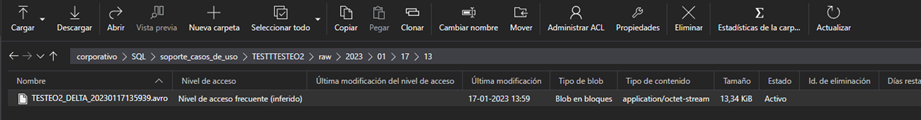

## 2. Capa Landing

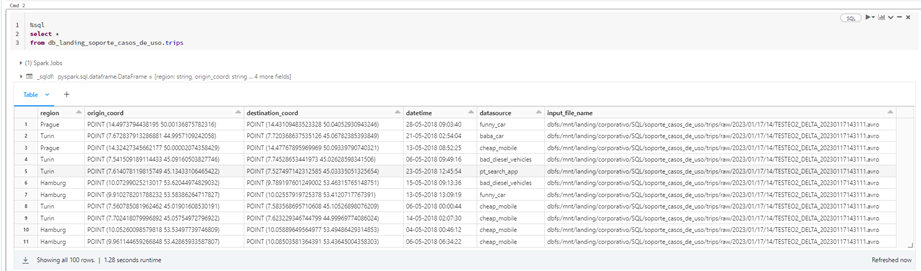

### Canalización de Ingesta a capa Landing

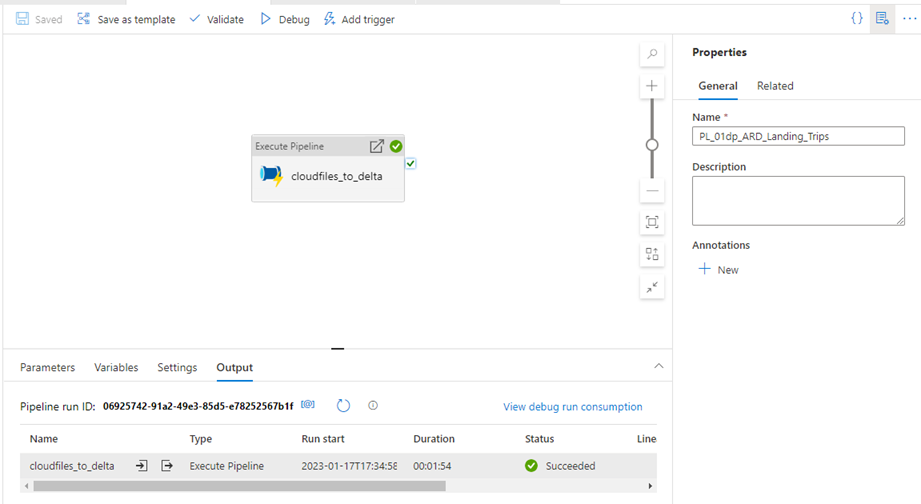

### Código Canalización de Ingesta a Landing

In [ ]:
{
    "name": "PL_01dp_ARD_Landing_Trips",
    "properties": {
        "activities": [
            {
                "name": "cloudfiles_to_delta",
                "type": "ExecutePipeline",
                "dependsOn": [],
                "userProperties": [],
                "typeProperties": {
                    "pipeline": {
                        "referenceName": "PL_00dp_ARD_tool_cloudfiles_to_delta",
                        "type": "PipelineReference"
                    },
                    "waitOnCompletion": true,
                    "parameters": {
                        "scope": "DataLakeProjectSecretScope",
                        "input_path": "/mnt/landing/corporativo/SQL/soporte_casos_de_uso/trips/raw/*/*/*/*",
                        "input_format": "com.databricks.spark.avro",
                        "output_path": "/mnt/landing/corporativo/SQL/soporte_casos_de_uso/trips/delta",
                        "checkpoint_location": "/mnt/landing/corporativo/SQL/soporte_casos_de_uso/trips/checkpoint",
                        "schema_path": "/mnt/landing/metadata/tecnica/landing/corporativo/sql/trips.json",
                        "database": "db_landing_soporte_casos_de_uso",
                        "table_name": "trips",
                        "cluster_id": "0124-154304-isles281"
                    }
                }
            }
        ],
        "folder": {
            "name": "DataOps/Landing Layer/SQL/Soporte Casos de Uso"
        },
        "annotations": [],
        "lastPublishTime": "2022-03-29T16:00:43Z"
    },
    "type": "Microsoft.DataFactory/factories/pipelines"
}


## 3. Capa Trusted

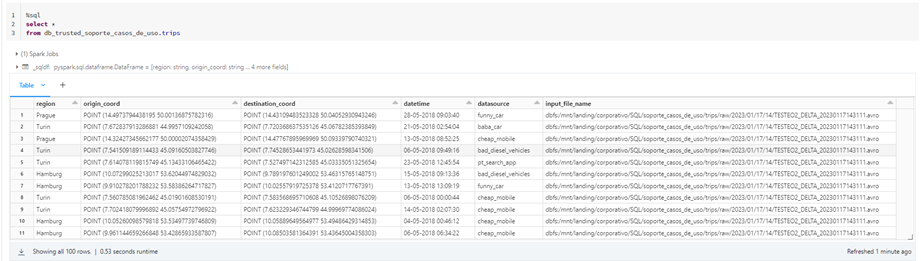

### Esquema de la capa trusted

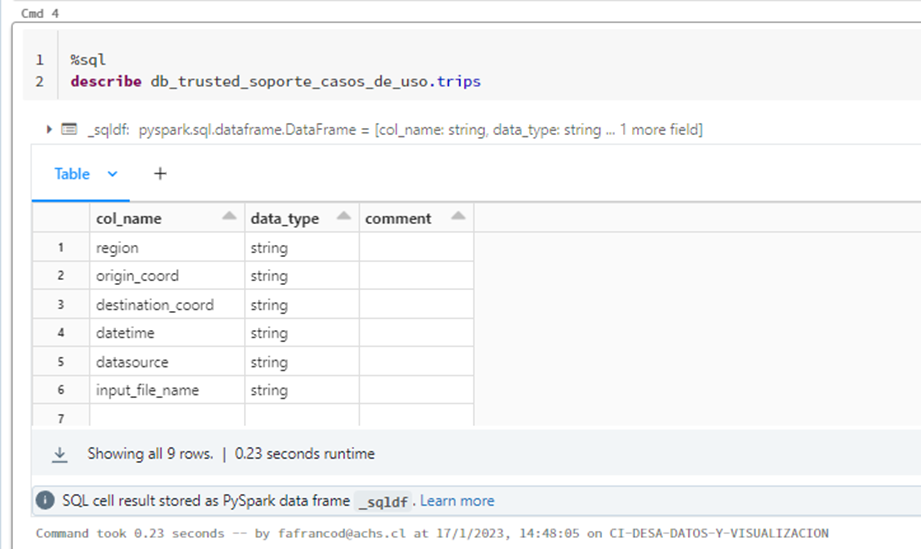

### Canalización capa Landing a Trusted

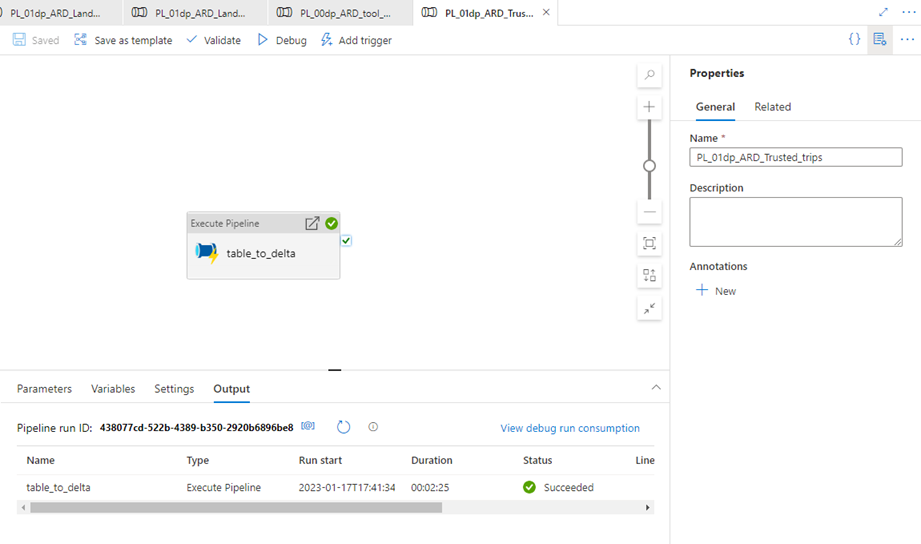

### Código de Landing a Trusted

In [ ]:
{
    "name": "PL_01dp_ARD_Trusted_trips",
    "properties": {
        "activities": [
            {
                "name": "table_to_delta",
                "type": "ExecutePipeline",
                "dependsOn": [],
                "userProperties": [],
                "typeProperties": {
                    "pipeline": {
                        "referenceName": "PL_00dp_ARD_tool_table_to_delta_v2",
                        "type": "PipelineReference"
                    },
                    "waitOnCompletion": true,
                    "parameters": {
                        "output_path": "/mnt/trusted/corporativo/SQL/soporte_casos_de_uso/trips/delta/",
                        "parameters_path": "/dbfs/mnt/landing/metadata/tecnica/trusted/corporativo/sql/soporte_casos_de_uso/parameters/trips.json",
                        "cluster_id": "0124-154304-isles281"
                    }
                }
            }
        ],
        "folder": {
            "name": "DataOps/Trusted Layer/SQL/Soporte Casos de Uso"
        },
        "annotations": [],
        "lastPublishTime": "2022-03-29T16:01:17Z"
    },
    "type": "Microsoft.DataFactory/factories/pipelines"
}


## 3. Capa Refined
Tratamiento de la Tabla Trusted mediante notebook en databricks.

In [ ]:
# Databricks notebook source
# MAGIC %md # Tabla Refined: cu_trips
# MAGIC ---
# MAGIC - Recibe el archivo de parámetros como argumento
# MAGIC - Obtiene vistas temporales desde el archivo de parámetros

# COMMAND ----------

# MAGIC %md ## 1. Importación Librería

# COMMAND ----------

# MAGIC %run Users/svc_desadatalake@achs.cl/DataOps/ard_tools_2.0/includes/ard_tools_v2

# COMMAND ----------

# MAGIC %md ## 2. Obtención y Procesamiento del Archivo de Parámetros
# MAGIC ----
# MAGIC La función __achslh.data.get_temp_views_from_parameters__: toma y procesa el archivo de parámetros, retornando vistas temporales:

# COMMAND ----------

dbutils.widgets.text("parameters_path", "")

# COMMAND ----------

parameters_path = achslh.utils.databricks.get_mandatory("parameters_path")
temp_views = achslh.data.get_temp_views_from_parameters(parameters_path)
print(f"Avalaible temp_views are: {json.dumps(temp_views, indent=4)}")



In [ ]:

# COMMAND ----------

n = 10
df = spark.sql("""select * from temp__db_trusted_soporte_casos_de_uso__trips""")
df = df.withColumn("origin_latitude",regexp_extract(col("origin_coord"), 'POINT \\(([0-9.]+)', 1))
df = df.withColumn("origin_longitude",regexp_extract(col("origin_coord"), 'POINT \\([0-9.]+ ([0-9.]+)', 1))
df = df.withColumn("destination_latitude",regexp_extract(col("destination_coord"), 'POINT \\(([0-9.]+)', 1))
df = df.withColumn("destination_longitude",regexp_extract(col("destination_coord"), 'POINT \\([0-9.]+ ([0-9.]+)', 1))
df.createOrReplaceTempView("trips")



In [ ]:
# COMMAND ----------

# MAGIC %md
# MAGIC Filtro de datos por bounding_box

# COMMAND ----------

from pyspark.sql.functions import to_date
min_lat = 7.52
min_long = 44.98
max_lat = 14.65
max_long = 53.62
bounding_box = ((min_lat, min_long), (max_lat, max_long))

df2 = spark.sql("""
  select 
  region
  , datetime
  , datasource
  , CAST(origin_latitude AS float) as origin_latitude
  , CAST(origin_longitude AS float) as origin_longitude
  , CAST(destination_latitude AS float) as destination_latitude
  , CAST(destination_longitude AS float) as destination_longitude
  from trips 
""")
# Conversión a date
df2 = df2.withColumn("date", to_date(col("datetime"), 'dd-MM-yyyy HH:mm:ss'))
df2 = df2.filter((col("origin_latitude") >= bounding_box[0][0]) & (col("origin_latitude") <= bounding_box[1][0]) & (col("origin_longitude") >= bounding_box[0][1]) & (col("origin_longitude") <= bounding_box[1][1]) & (col("destination_latitude") >= bounding_box[0][0]) & (col("destination_latitude") <= bounding_box[1][0]) & (col("destination_longitude") >= bounding_box[0][1]) & (col("destination_longitude") <= bounding_box[1][1]) )
df2.createOrReplaceTempView("trips_filtered")



In [ ]:
# COMMAND ----------

# MAGIC %md
# MAGIC Conteo de viajes agrupados por semana y por región

# COMMAND ----------

# MAGIC %sql
# MAGIC CREATE OR REPLACE TEMP VIEW avg_trips_per_week
# MAGIC WITH weekly_counts_by_region AS (
# MAGIC   SELECT 
# MAGIC     date_trunc('week', date) AS week,
# MAGIC     region,
# MAGIC     COUNT(*) AS count
# MAGIC   FROM trips_filtered
# MAGIC   GROUP BY week, region
# MAGIC )
# MAGIC 
# MAGIC SELECT
# MAGIC   week,
# MAGIC   region,
# MAGIC   AVG(count) OVER (PARTITION BY region ORDER BY week) AS avg_trips_per_week
# MAGIC FROM weekly_counts_by_region
# MAGIC ORDER BY week

# COMMAND ----------

# MAGIC %md ## 4. Salida del Notebook
# MAGIC 
# MAGIC Debe pasarse el nombre de la vista temporal final como argumento a la función __achslh.utils.databricks.exit_notebook_with_temp_view__:

# COMMAND ----------

achslh.utils.databricks.exit_notebook_with_temp_view("avg_trips_per_week")


## Resultados
Se obtiene el número de viajes promedio semanal que ocurrieron dentro de la bounding_box definida. La Data Scientist ahora puede utilizar este mismo notebook databricks para hacer sus análisis o puede usar una tabla con este mismo resultado. 
 - La tabla refined que muestra o "imprime" este resultado, por motivos de orden de mi organización, no la haré visible en la base de datos.

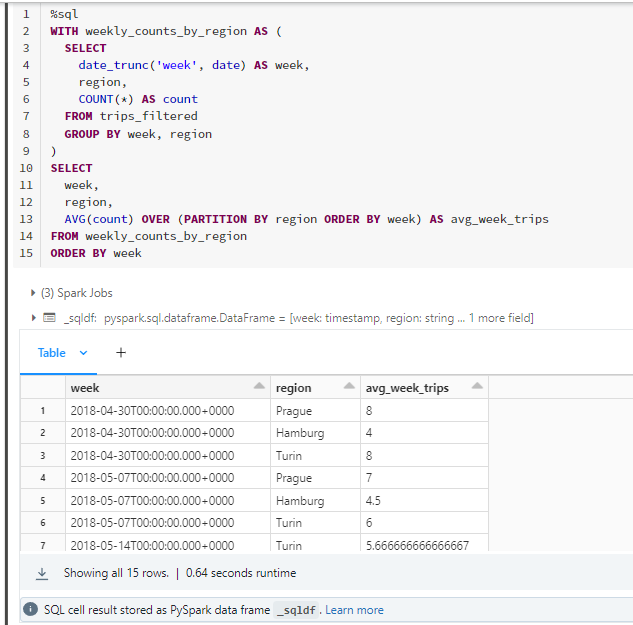

## Respecto a la escalabilidad del proyecto

Este enfoque en la nube del procesamiento de datos es on-demand, es decir, se utilizan clústers a la medida del cliente. Es por ello que es alta mente escalable esta solución. El clúster utilizado es de 28Gb de RAM y 8 Cores, lo que permitió una respuesta en el notebook de databricks de 1.22 segundos siendo 100 datos. Tomando esto en cuenta además de que los datos son almacenados en formato .parquet, el procesamiento de BigData está asegurado.

## Respecto al monitoreo de la ingesta de datos sin usar polling

Existen varias vías para notificar el status de ingesta de un pipeline:
- Data Factory permite enviar notificaciones en función de eventos. Por lo que en caso de que la ingesta se esté saliendo de los márgenes estimados, como por ejemplo, está tomándole más tiempo del habitual o si la ingesta se cae, es posible enviar notificaciones a usuarios.
- Es posible usar el Monitoreo de Data Factory para revisar diariamente el status de ingesta y hacer Re-Run en caso de fallas.
- También es posible generar una función que es gatillada cuando un Pipeline Run termina correctamente, enviando así un mail a ciertos usuarios.